0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


1. Load data

In [2]:
# Load datasets
sentiment = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.xlsx")


/tmp/ipython-input-1959410678.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv("/content/historical_data.csv")


2. Basic data checks (Part A)

In [3]:
def data_summary(df):
    return {
        "rows": df.shape[0],
        "columns": df.shape[1],
        "missing_values": df.isna().sum().sum(),
        "duplicates": df.duplicated().sum()
    }

print("Sentiment:", data_summary(sentiment))
print("Trades:", data_summary(trades))


Sentiment: {'rows': 2644, 'columns': 4, 'missing_values': np.int64(0), 'duplicates': np.int64(0)}
Trades: {'rows': 55784, 'columns': 16, 'missing_values': np.int64(5), 'duplicates': np.int64(0)}


3. Time conversion & alignment

In [4]:
# Convert sentiment date
sentiment["date"] = pd.to_datetime(sentiment["date"])

# Convert trade timestamp
trades["date"] = pd.to_datetime(trades["Timestamp"], unit="ms").dt.date
trades["date"] = pd.to_datetime(trades["date"])

# Merge sentiment onto trades
df = trades.merge(
    sentiment[["date", "classification"]],
    on="date",
    how="left"
)

df["classification"].value_counts()


,count
classification,
Fear,30662
Extreme Greed,6935
Greed,6866
Neutral,3207


4. Feature engineering (daily trader metrics)

In [5]:
daily_trader = (
    df.groupby(["Account", "date", "classification"])
      .agg(
          daily_pnl=("Closed PnL", "sum"),
          trades_per_day=("Trade ID", "count"),
          avg_trade_size=("Size USD", "mean"),
          long_ratio=("Side", lambda x: (x == "BUY").mean())
      )
      .reset_index()
)

daily_trader.head()


,Account,date,classification,daily_pnl,trades_per_day,avg_trade_size,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,-3.275059e+05,462,14810.891818,0.300866
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,1.927736e+06,3356,16345.241940,0.468415
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,2.060745e+04,320,2492.749906,0.453125
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,2.609175e+04,1675,2137.469845,0.424478
4,0x420ab45e0bd8863569a5efbb9c05d91f40624641,2024-10-27,Greed,1.610257e+04,125,6480.628160,0.144000


5. Performance vs Sentiment (Part B – Q1)

In [6]:
pnl_by_sentiment = (
    daily_trader
    .groupby("classification")["daily_pnl"]
    .describe()
)

pnl_by_sentiment


,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme Greed,4.0,45632.376978,94912.077208,-7919.471032,-1979.867758,1303.447378,48915.692115,1.878421e+05
Fear,11.0,361860.165243,546052.704179,8751.751449,87519.037910,183403.024142,372723.541475,1.927736e+06
Greed,12.0,126083.135180,424393.660762,-327505.900056,119.556937,20766.479658,66610.809065,1.421756e+06
Neutral,4.0,45539.571589,76345.477294,-25991.506339,-6497.754545,31293.172160,83330.498294,1.455634e+05


Plot: Daily PnL distribution

<Figure size 640x480 with 0 Axes>

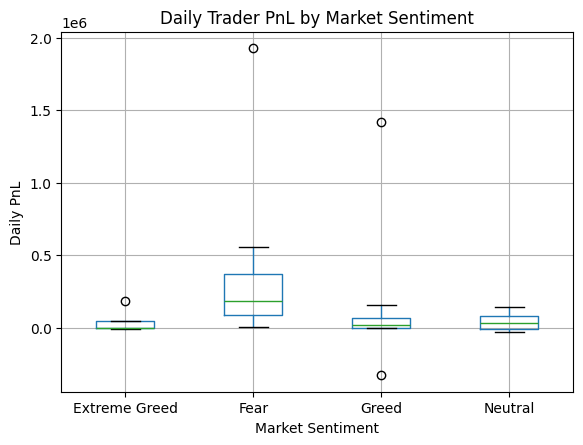

In [7]:
plt.figure()
daily_trader.boxplot(column="daily_pnl", by="classification")
plt.title("Daily Trader PnL by Market Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()


6. Behavioral changes vs sentiment (Part B – Q2)

In [8]:
freq_by_sentiment = (
    daily_trader
    .groupby("classification")["trades_per_day"]
    .mean()
)

freq_by_sentiment


,trades_per_day
classification,
Extreme Greed,1733.750000
Fear,2787.454545
Greed,572.166667
Neutral,801.750000


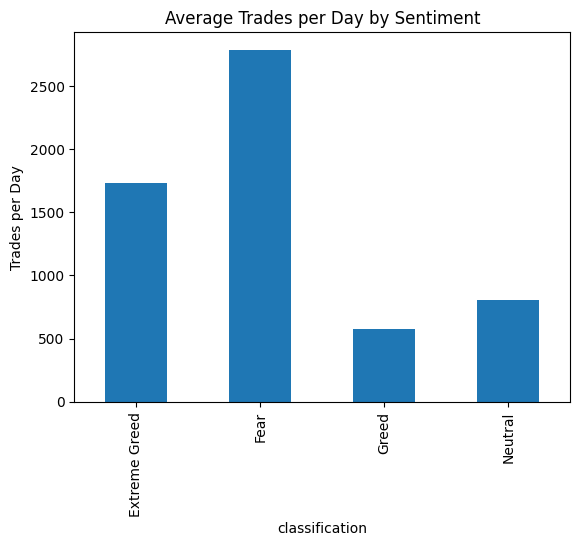

In [9]:
plt.figure()
freq_by_sentiment.plot(kind="bar")
plt.title("Average Trades per Day by Sentiment")
plt.ylabel("Trades per Day")
plt.show()


Position bias (long/short)

In [10]:
long_ratio_by_sentiment = (
    daily_trader
    .groupby("classification")["long_ratio"]
    .mean()
)

long_ratio_by_sentiment


,long_ratio
classification,
Extreme Greed,0.611062
Fear,0.493960
Greed,0.410201
Neutral,0.417900


7. Trader segmentation (Part B – Q3)

In [11]:
activity = (
    daily_trader.groupby("Account")["trades_per_day"]
    .mean()
    .reset_index(name="avg_trades")
)

threshold = activity["avg_trades"].median()

activity["segment"] = np.where(
    activity["avg_trades"] >= threshold,
    "Frequent Traders",
    "Infrequent Traders"
)

segmented = daily_trader.merge(activity[["Account", "segment"]], on="Account")


In [12]:
segment_perf = (
    segmented
    .groupby(["segment", "classification"])["daily_pnl"]
    .mean()
    .reset_index()
)

segment_perf


,segment,classification,daily_pnl
0,Frequent Traders,Extreme Greed,60843.169305
1,Frequent Traders,Fear,545220.588588
2,Frequent Traders,Greed,180538.532164
3,Frequent Traders,Neutral,12198.279327
4,Infrequent Traders,Extreme Greed,0.000000
5,Infrequent Traders,Fear,141827.657230
6,Infrequent Traders,Greed,49845.579402
7,Infrequent Traders,Neutral,145563.448374


8. Simple win-rate proxy

In [13]:
daily_trader["win"] = daily_trader["daily_pnl"] > 0

win_rate = (
    daily_trader
    .groupby("classification")["win"]
    .mean()
)

win_rate


,win
classification,
Extreme Greed,0.500000
Fear,1.000000
Greed,0.833333
Neutral,0.750000


9. Tables to include in submission

In [14]:
summary_table = (
    daily_trader
    .groupby("classification")
    .agg(
        avg_pnl=("daily_pnl", "mean"),
        pnl_std=("daily_pnl", "std"),
        win_rate=("win", "mean"),
        avg_trades=("trades_per_day", "mean")
    )
)

summary_table


,avg_pnl,pnl_std,win_rate,avg_trades
classification,,,,
Extreme Greed,45632.376978,94912.077208,0.500000,1733.750000
Fear,361860.165243,546052.704179,1.000000,2787.454545
Greed,126083.135180,424393.660762,0.833333,572.166667
Neutral,45539.571589,76345.477294,0.750000,801.750000


10. (Optional Bonus) Simple predictive model

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model_df = daily_trader.dropna().copy()

X = model_df[["trades_per_day", "avg_trade_size", "long_ratio"]]
y = model_df["win"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.89      0.94         9

    accuracy                           0.90        10
   macro avg       0.75      0.94      0.80        10
weighted avg       0.95      0.90      0.91        10

